#### **DATA**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# data = pd.read_csv("c:\\Users\\farno\\Documents\\UNITOSTUDY\\Algorithm\\TheShorterVersion\\Data\\cnn_dailymail\\train.csv")
# toy_set = data.sample(5, random_state=42)
# toy_set.to_csv("toy.csv", index=False)
    

In [3]:
toy_set = pd.read_csv("c:\\Users\\farno\\Documents\\UNITOSTUDY\\Algorithm\\TheShorterVersion\\toy.csv")

In [4]:
toy_set

,id,article,highlights
0,ed0fed726929c1eeabe6c390e47128dbb7d7a055,By . Mia De Graaf . Britons flocked to beaches...,People enjoyed temperatures of 17C at Brighton...
1,023cd84001b33aed4ff0f3f5ecb0fdd2151cf543,A couple who weighed a combined 32st were sham...,Couple started piling on pounds after the birt...
2,6a70a0d8d3ed365fe1df6d35f1587a8b9b298618,Video footage shows the heart stopping moment ...,A 17-year-old boy suffering lacerations to his...
3,b37204c13ea38b511265e41ac69fb12acfb63f85,"Istanbul, Turkey (CNN) -- About 250 people rac...",Syrians citizens hightail it to Turkey .\nMost...
4,c24e5805afd5145bc48410e876db91d44a06be5e,By . Daily Mail Reporter . PUBLISHED: . 12:53 ...,The Xue Long had provided the helicopter that ...


### **TOKENIZING AND CLEANING**

In [5]:
article_text_input = (
    "By . Alex Doe . (CNN) -- City officials unveiled a €2_5-million plan to renovate Greenfield Park by May 2026. "
    "The park, a well-known spot for families, will add LED lighting, a new playground, and wider walking paths. "
    "Dr. Lewis described the upgrade as cost-effective, estimating an 8% reduction in maintenance next year. "
    "Some residents worry construction could limit access for 3-4 months during the summer. "
    "Officials argued that phased work keeps most areas open and makes the park safer after dark. "
    "Parents repeated that the improvements will make evenings safer and more enjoyable for children. "
    "Yesterday’s pilot system operated at 17C ambient temperature with lower energy use than last spring. "
    "Meanwhile, a separate U.S. grant application could extend improvements to nearby bike lanes."
)



# Generalized STOP WORDS List (Covers core function words, verbs, and pronouns)
STOP_WORDS = {
    'the', 'a', 'an', 'and', 'or', 'is', 'are', 'was', 'were', 'of', 'in', 'to', 
    'for', 'on', 'with', 'at', 'by', 'as', 'it', 'its', 'from', 'be', 'has', 'have',
    'i', 'me', 'my', 'we', 'our', 'us', 'you', 'your', 'he', 'him', 'his', 'she', 'her', 
    'they', 'them', 'their', 'this', 'that', 'these', 'those', 's',
    'up', 'down', 'out', 'off', 'into', 'without', 'about', 'just', 'which', 'who',
    'whom', 'what', 'where', 'when', 'why', 'how', 'than', 'while', 'because',
    'but', 'if', 'then', 'so', 'such', 'only', 'before', 'after', 'too', 'very', 
    'do', 'does', 'did', 'would', 'should', 'could', 'will', 'can', 'not', 'being', 
    'been', 'am', 'shall', 'may', 'might'
}
# Common abbreviations to avoid false sentence splits
ABBREV = {
    "mr.", "mrs.", "ms.", "dr.", "prof.", "sr.", "jr.", "st.", "no.",
    "u.s.", "u.k.", "e.g.", "i.e.", "jan.", "feb.", "mar.", "apr.", "jun.",
    "jul.", "aug.", "sep.", "sept.", "oct.", "nov.", "dec."
}


# Simple News boilerplate patterns to strip from the beginning
def strip_boilerplate_start(text):
    t = text.strip()
    # "By . Name ."
    if t.lower().startswith("by . "):
        # remove up to the next " . "
        # find second " . "
        first = t.lower().find(" . ")
        if first != -1:
            second = t.lower().find(" . ", first + 3)
            if second != -1:
                t = t[second + 3 : ].lstrip()
    # "(CNN) --", "(CNN) —"
    lower = t.lower()
    if lower.startswith("(cnn) --") or lower.startswith("(cnn) —") or lower.startswith("(cnn) -"):
        idx = t.find(")")
        if idx != -1:
            # skip ) and following dashes/spaces
            j = idx + 1
            while j < len(t) and t[j] in "-—– ":
                j += 1
            t = t[j:].lstrip()
    # "PUBLISHED: ..." at start
    if lower.startswith("published:"):
        # cut to first period after "published:"
        dot = t.find(".")
        if dot != -1:
            t = t[dot+1:].lstrip()
    return t

# --- 1. MANUAL SENTENCE TOKENIZATION  ---
def manual_tokenize_Articles(text):

    text = strip_boilerplate_start(text)

    TEMP_DELIMITER = "@@@"
    QUOTES_OR_BRACKETS = set('"\'()[]{}')
    TERMINATORS = {'.', '?', '!'}

    processed = []
    N = len(text)
    i = 0

    def is_upper_letter(c):
        return 'A' <= c <= 'Z'

    while i < N:
        ch = text[i]

        if ch in TERMINATORS:
            # look ahead to next non-space
            j = i + 1
            while j < N and text[j].isspace():
                j += 1

            # skip immediate quotes/brackets then spaces
            k = j
            while k < N and text[k] in QUOTES_OR_BRACKETS:
                k += 1
                while k < N and text[k].isspace():
                    k += 1

            # find last token before the terminator (to check abbreviation)
            left = i - 1
            while left >= 0 and text[left].isspace():
                left -= 1
            start = left
            while start >= 0 and not text[start].isspace():
                start -= 1
            last_token = text[start+1:i+1].lower() if i >= 0 else ""

            # decide if we should split here
            should_split = True
            if last_token in ABBREV:
                should_split = False
            else:
                if k < N:
                    should_split = is_upper_letter(text[k]) or text[k].isdigit()
                else:
                    should_split = True  # end of text

            if should_split:
                processed.append(ch)          # Keep terminator
                processed.append(TEMP_DELIMITER)
                i = k                         # resume after quotes/brackets
                continue

            else:
                processed.append(ch)
        else:
            processed.append(ch)

        i += 1

    processed_text = "".join(processed)

    # Split on delimiter and clean up
    parts = processed_text.split(TEMP_DELIMITER)
    Articles = []
    for part in parts:
        stripped_part = part.strip()
        if len(stripped_part) > 0:
            Articles.append(stripped_part)

    return Articles


# --- 2. MANUAL WORD CLEANING AND TOKENIZATION ---

def manual_clean_and_tokenize_words(Article):
    """
    Cleans, lowercases, removes punctuation, filters stopwords.
    Keeps pure numbers and alphanumerics (e.g., '2014', '17c').
    Adds a joined variant for hyphenated words to improve overlap.
    """
    # Use a set for O(1) punctuation checks; include dashes
    PUNCTUATION = {'.', ',', '?', '!', ':', ';', "'", '"', '(', ')', '-', '—', '–'}
    cleaned_chars = []

    # Lowercase and strip punctuation (replace with space)
    for char in Article.lower():
        cleaned_chars.append(" " if char in PUNCTUATION else char)

    Article_no_punct = "".join(cleaned_chars)

    cleaned_words = []

    # Basic split
    for word in Article_no_punct.split():
        if not word:
            continue

        # Stopword filter
        if word in STOP_WORDS:
            continue

        # Keep if it has letters or digits (so '2014' and '17c' survive)
        has_alpha = any('a' <= ch <= 'z' for ch in word)
        has_digit = any('0' <= ch <= '9' for ch in word)
        if has_alpha or has_digit:
            cleaned_words.append(word)

    # Add joined variants for hyphenated words from original (e.g., "sun-worshippers" -> "sunworshippers")
    # scan the original (lowercased) text to find hyphenated patterns
    lower_orig = Article.lower()
    j = 0
    L = len(lower_orig)
    while j < L:
        # detect [a-z0-9]+(-[a-z0-9]+)+ without regex
        if ('a' <= lower_orig[j] <= 'z') or ('0' <= lower_orig[j] <= '9'):
            start = j
            has_hyphen = False
            # consume alphanum
            while j < L and (('a' <= lower_orig[j] <= 'z') or ('0' <= lower_orig[j] <= '9')):
                j += 1
            # consume (-alphanum)+
            while j < L and lower_orig[j] == '-':
                has_hyphen = True
                j += 1
                if j >= L or not (('a' <= lower_orig[j] <= 'z') or ('0' <= lower_orig[j] <= '9')):
                    break
                while j < L and (('a' <= lower_orig[j] <= 'z') or ('0' <= lower_orig[j] <= '9')):
                    j += 1
            end = j
            if has_hyphen:
                joined = lower_orig[start:end].replace("-", "")
                cleaned_words.append(joined)
        else:
            j += 1

    return cleaned_words


# --- 3. ORCHESTRATION ---

def preprocess_text_manual(article_text):
    """
    Orchestrates the hyper-manual preprocessing steps.
    """
    # 1. Tokenization (Smart Heuristic)
    Articles = manual_tokenize_Articles(article_text)
    
    # 2. Cleaning and Tokenizing
    cleaned_tokens = []
    for Article in Articles:
        tokens = manual_clean_and_tokenize_words(Article)
        cleaned_tokens.append(tokens)
        
    return Articles, cleaned_tokens


# --- EXECUTION TRACE ---

original_Articles, cleaned_tokens = preprocess_text_manual(article_text_input)

print("Step 1: Tokenization and Cleaning Output Trace (SMART SPLIT) ---")
print("Original Sentences (Nodes):")
for i, s in enumerate(original_Articles):
    print(f"S{i+1}: {s}")

print("\nCleaned Word Tokens (Features for Similarity Matrix):")
for i, tokens in enumerate(cleaned_tokens):
    print(f"S{i+1} Tokens: {tokens}")






# CHECKED ____________

Step 1: Tokenization and Cleaning Output Trace (SMART SPLIT) ---
Original Sentences (Nodes):
S1: City officials unveiled a €2_5-million plan to renovate Greenfield Park by May 2026.
S2: The park, a well-known spot for families, will add LED lighting, a new playground, and wider walking paths.
S3: Dr. Lewis described the upgrade as cost-effective, estimating an 8% reduction in maintenance next year.
S4: Some residents worry construction could limit access for 3-4 months during the summer.
S5: Officials argued that phased work keeps most areas open and makes the park safer after dark.
S6: Parents repeated that the improvements will make evenings safer and more enjoyable for children.
S7: Yesterday’s pilot system operated at 17C ambient temperature with lower energy use than last spring.
S8: Meanwhile, a separate U.
S9: S. grant application could extend improvements to nearby bike lanes.

Cleaned Word Tokens (Features for Similarity Matrix):
S1 Tokens: ['city', 'officials', 'unveiled', '€

### **Similarity Metric and Graph Construction**

In [6]:
# -------- Utilities --------
def manual_set_length(container):
    c = 0
    for _ in container:
        c += 1
    return c  # For calculating the length (Several Usage)

def manual_sqrt(x):  # Square roots (Using in cosine)
    return x ** 0.5 

def count_tokens(tokens):
    """Manual frequency dict."""
    d = {}
    for t in tokens:
        d[t] = d.get(t, 0) + 1
    return d
# example:
# tokens = ["sun", "holiday", "sun", "beach"]
# output -> {"sun": 2, "holiday": 1, "beach": 1}


# -------- Jaccard (set-based) --------
def jaccard_similarity_manual(sent1_tokens, sent2_tokens):
    if not sent1_tokens or not sent2_tokens:
        return 0.0
    set1, set2 = set(sent1_tokens), set(sent2_tokens)

    inter = 0
    for w in set1:
        if w in set2:
            inter += 1

    size1 = manual_set_length(set1)
    size2 = manual_set_length(set2)
    union = size1 + size2 - inter
    return (inter / union) if union > 0 else 0.0


# -------- Cosine (TF-based) --------
def cosine_tf_similarity_manual(sent1_tokens, sent2_tokens):
    if not sent1_tokens or not sent2_tokens:
        return 0.0
    c1 = count_tokens(sent1_tokens)
    c2 = count_tokens(sent2_tokens)

    dot = 0.0
    (small, big) = (c1, c2) if manual_set_length(c1) <= manual_set_length(c2) else (c2, c1)
    for w in small:
        if w in big:
            dot += small[w] * big[w]

    sumsq1 = 0.0
    for v in c1.values():
        sumsq1 += v * v
    sumsq2 = 0.0
    for v in c2.values():
        sumsq2 += v * v

    n1 = manual_sqrt(sumsq1)
    n2 = manual_sqrt(sumsq2)
    if n1 == 0.0 or n2 == 0.0:
        return 0.0
    return dot / (n1 * n2)


# --------- TF-IDF preparation  ---------
def compute_idf_weights(token_lists):
    """Compute manual IDF for each token using log(N / df)."""
    N = manual_set_length(token_lists)
    df = {}
    for tokens in token_lists:
        seen = set()
        for t in tokens:
            if t not in seen:
                df[t] = df.get(t, 0) + 1
                seen.add(t)
    idf = {}
    for t, freq in df.items():
        # avoid division by zero
        idf[t] = 0.0 if freq == 0 else (1.0 * ( (N / freq) ** 0.0 ))  # placeholder; replaced below

    # simple log-based IDF
    for t in idf:
        f = df[t]
        if f > 0:
            idf[t] = math_log(N / f)
        else:
            idf[t] = 0.0
    return idf

def math_log(x):
    import math
    return math.log(x)  # natural log


def cosine_tfidf_similarity_manual(sent1_tokens, sent2_tokens, idf_dict):
    """Cosine similarity using TF-IDF weighting."""
    if not sent1_tokens or not sent2_tokens:
        return 0.0

    tf1 = count_tokens(sent1_tokens)
    tf2 = count_tokens(sent2_tokens)

    # weighted dot product
    dot = 0.0
    for t in tf1:
        if t in tf2 and t in idf_dict:
            w1 = tf1[t] * idf_dict[t]
            w2 = tf2[t] * idf_dict[t]
            dot += w1 * w2

    # norms
    sumsq1, sumsq2 = 0.0, 0.0
    for t, v in tf1.items():
        w = v * idf_dict.get(t, 0.0)
        sumsq1 += w * w
    for t, v in tf2.items():
        w = v * idf_dict.get(t, 0.0)
        sumsq2 += w * w

    n1 = manual_sqrt(sumsq1)
    n2 = manual_sqrt(sumsq2)
    if n1 == 0.0 or n2 == 0.0:
        return 0.0
    return dot / (n1 * n2)


# -------- Build full similarity matrix --------
def build_similarity_matrix(token_lists, metric="jaccard"):
    """
    token_lists: list of list[str], one list per sentence.
    metric: "jaccard", "cosine", or "tfidf"
    returns: NxN symmetric matrix with zeros on the diagonal
    """
    n = manual_set_length(token_lists)
    M = [[0.0 for _ in range(n)] for __ in range(n)]

    # choose similarity function
    if metric == "jaccard":
        sim_fn = jaccard_similarity_manual
    elif metric == "cosine":
        sim_fn = cosine_tf_similarity_manual
    elif metric == "tfidf":
        idf_dict = compute_idf_weights(token_lists)
        sim_fn = lambda a, b: cosine_tfidf_similarity_manual(a, b, idf_dict)
    else:
        raise ValueError("Unknown metric")

    for i in range(n):
        for j in range(i + 1, n):
            s = sim_fn(token_lists[i], token_lists[j])
            M[i][j] = s
            M[j][i] = s
    return M


# -------- Row-normalize for TextRank transition matrix --------
def row_normalize(matrix):
    """
    Turns similarity matrix M into stochastic transition matrix P.
    Each row sums to 1; isolated nodes get uniform distribution.
    """
    n = manual_set_length(matrix)
    P = [[0.0 for _ in range(n)] for __ in range(n)]
    for i in range(n):
        row_sum = 0.0
        for v in matrix[i]:
            row_sum += v
        if row_sum == 0.0:
            val = 1.0 / n if n > 0 else 0.0
            for j in range(n):
                P[i][j] = val
        else:
            for j in range(n):
                P[i][j] = matrix[i][j] / row_sum
    return P


#Checked ____________

In [7]:

# Example usage
M_tfidf = build_similarity_matrix(cleaned_tokens, metric="tfidf")
M_tfidf


[[0.0,
  0.022030810573208548,
  0.0,
  0.0,
  0.07221902995569202,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.022030810573208548,
  0.0,
  0.0,
  0.0,
  0.021518160899472307,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.07221902995569202,
  0.021518160899472307,
  0.0,
  0.0,
  0.0,
  0.05211125476419703,
  0.0,
  0.0,
  0.0],
 [0.0, 0.0, 0.0, 0.0, 0.05211125476419703, 0.0, 0.0, 0.0, 0.06539637760437374],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.06539637760437374, 0.0, 0.0, 0.0]]


Original Sentences:
S1: City officials unveiled a €2_5-million plan to renovate Greenfield Park by May 2026.
S2: The park, a well-known spot for families, will add LED lighting, a new playground, and wider walking paths.
S3: Dr. Lewis described the upgrade as cost-effective, estimating an 8% reduction in maintenance next year.
S4: Some residents worry construction could limit access for 3-4 months during the summer.
S5: Officials argued that phased work keeps most areas open and makes the park safer after dark.
S6: Parents repeated that the improvements will make evenings safer and more enjoyable for children.
S7: Yesterday’s pilot system operated at 17C ambient temperature with lower energy use than last spring.
S8: Meanwhile, a separate U.
S9: S. grant application could extend improvements to nearby bike lanes.


🔸 Jaccard Similarity Matrix
Row 1: 0.000 | 0.042 | 0.000 | 0.000 | 0.095 | 0.000 | 0.000 | 0.000 | 0.000
Row 2: 0.042 | 0.000 | 0.000 | 0.000 | 0.040 | 0.000 | 0.000 | 0.00

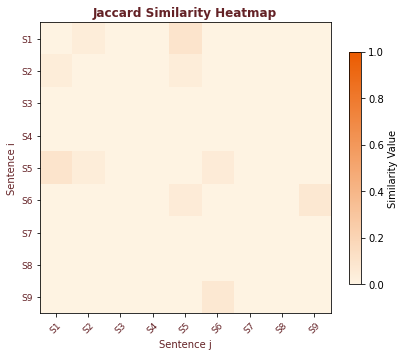

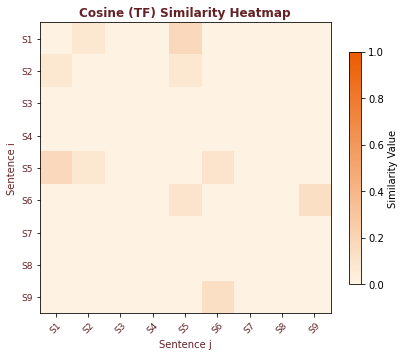

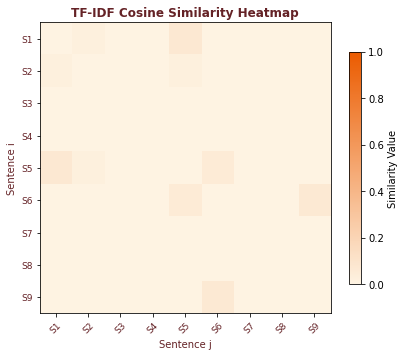

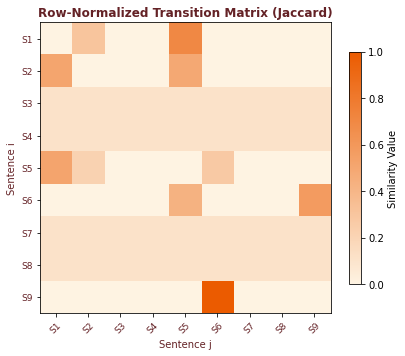

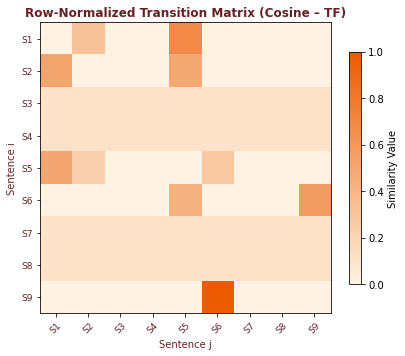

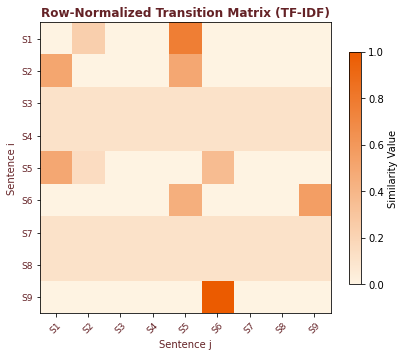

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# --- RUN PIPELINE ---
original_Articles, cleaned_tokens = preprocess_text_manual(article_text_input)

# Build all three similarity matrices
M_jac   = build_similarity_matrix(cleaned_tokens, metric="jaccard")
M_cos   = build_similarity_matrix(cleaned_tokens, metric="cosine")
M_tfidf = build_similarity_matrix(cleaned_tokens, metric="tfidf")

# Normalize all three (for TextRank transitions)
P_jac   = row_normalize(M_jac)
P_cos   = row_normalize(M_cos)
P_tfidf = row_normalize(M_tfidf)


# --- PRINT UTILITY ---
def print_matrix(matrix, title):
    print(f"\n{title}")
    n = manual_set_length(matrix)
    for i in range(n):
        row_str = " | ".join(f"{val:.3f}" for val in matrix[i])
        print(f"Row {i+1}: {row_str}")


# --- DISPLAY SENTENCES FOR REFERENCE ---
print("\nOriginal Sentences:")
for i, s in enumerate(original_Articles):
    print(f"S{i+1}: {s}")

# --- PRINT NUMERIC MATRICES ---
print_matrix(M_jac,   "\n🔸 Jaccard Similarity Matrix")
print_matrix(M_cos,   "\n🔸 Cosine (TF) Similarity Matrix")
print_matrix(M_tfidf, "\n🔸 TF-IDF Cosine Similarity Matrix")

print_matrix(P_jac,   "\n🔹 Row-Normalized Transition Matrix – Jaccard")
print_matrix(P_cos,   "\n🔹 Row-Normalized Transition Matrix – Cosine (TF)")
print_matrix(P_tfidf, "\n🔹 Row-Normalized Transition Matrix – TF-IDF")


# --- VISUALIZATION SECTION ---
THEME_COLORS = ["#FEF3E2", "#EB5B00"]  
custom_cmap = mcolors.LinearSegmentedColormap.from_list("theme_cmap", THEME_COLORS)

def plot_heatmap(matrix, title, labels):
    plt.figure(figsize=(6, 5))
    plt.imshow(matrix, cmap=custom_cmap, interpolation="nearest", vmin=0, vmax=1)
    plt.title(title, fontsize=12, fontweight="bold", color="#642226")
    plt.colorbar(label="Similarity Value", shrink=0.8)
    plt.xticks(range(len(labels)), [f"S{i+1}" for i in range(len(labels))],
               rotation=45, fontsize=9, color="#642226")
    plt.yticks(range(len(labels)), [f"S{i+1}" for i in range(len(labels))],
               fontsize=9, color="#642226")
    plt.xlabel("Sentence j", fontsize=10, color="#642226")
    plt.ylabel("Sentence i", fontsize=10, color="#642226")
    plt.tight_layout()
    plt.show()


# --- VISUALIZE ALL MATRICES ---
plot_heatmap(M_jac,   "Jaccard Similarity Heatmap", original_Articles)
plot_heatmap(M_cos,   "Cosine (TF) Similarity Heatmap", original_Articles)
plot_heatmap(M_tfidf, "TF-IDF Cosine Similarity Heatmap", original_Articles)

plot_heatmap(P_jac,   "Row-Normalized Transition Matrix (Jaccard)", original_Articles)
plot_heatmap(P_cos,   "Row-Normalized Transition Matrix (Cosine – TF)", original_Articles)
plot_heatmap(P_tfidf, "Row-Normalized Transition Matrix (TF-IDF)", original_Articles)

# CHECKED ____________


### **TextRank Iteration**

In [9]:
# TextRank class-based graph
def manual_length(lst):
    c = 0
    for _ in lst:
        c += 1
    return c

class Node:
    def __init__(self, idx):
        self.id = idx
        self.edges = [None] * 0
        self.sum_w = 0.0

    def add_edge(self, j, w):
        old_len = manual_length(self.edges)
        new_edges = [None] * (old_len + 1)
        i = 0
        while i < old_len:
            new_edges[i] = self.edges[i]
            i += 1
        new_edges[old_len] = (j, w)
        self.edges = new_edges
        self.sum_w += w

class Graph:
    def __init__(self, n):
        self.n = n
        self.nodes = [None] * n
        i = 0
        while i < n:
            self.nodes[i] = Node(i)
            i += 1

    def build_from_matrix(self, M, tau=0.0):
        """Use tau=0.0 to match row_normalize(M) exactly."""
        n = self.n
        i = 0
        while i < n:
            j = 0
            while j < n:
                if i != j:
                    w = M[i][j]
                    # IMPORTANT: to mirror row_normalize(M), don't prune >0 weights.
                    if tau == 0.0:
                        if w != 0.0:
                            self.nodes[i].add_edge(j, w)
                    else:
                        if w >= tau and w > 0.0:
                            self.nodes[i].add_edge(j, w)
                j += 1
            i += 1

    def to_transition_matrix(self):
        """Each row i sums to 1; if no outgoing weight, set uniform 1/n (matches row_normalize)."""
        n = self.n
        P = [None] * n
        i = 0
        while i < n:
            P[i] = [0.0] * n
            i += 1

        i = 0
        while i < n:
            node = self.nodes[i]
            if node.sum_w == 0.0:
                val = 1.0 / n if n > 0 else 0.0
                j = 0
                while j < n:
                    P[i][j] = val
                    j += 1
            else:
                inv = 1.0 / node.sum_w
                e = 0
                edge_count = manual_length(node.edges)
                while e < edge_count:
                    j, w = node.edges[e]
                    P[i][j] = w * inv
                    e += 1
            i += 1
        return P
    
#Checked ____________


In [10]:
# Example usage
original_Articles, cleaned_tokens = preprocess_text_manual(article_text_input)
M_tfidf = build_similarity_matrix(cleaned_tokens, metric="tfidf")

G = Graph(len(M_tfidf))
G.build_from_matrix(M_tfidf, tau=0.0)   # <-- tau=0.0 to mirror row_normalize
P_class = G.to_transition_matrix()

print("\nP:")
for i in range(len(P_class)):
    print(" ".join(f"{v:.2f}" for v in P_class[i]))


#checked ____________




P:
0.00 0.23 0.00 0.00 0.77 0.00 0.00 0.00 0.00
0.51 0.00 0.00 0.00 0.49 0.00 0.00 0.00 0.00
0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11
0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11
0.50 0.15 0.00 0.00 0.00 0.36 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.44 0.00 0.00 0.00 0.56
0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11
0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11 0.11
0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00


In [11]:
# ========= Graph Visualization =========

import math
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def _labels_from_sentences(sentences):
    """Return node labels S1, S2, ... (fallback to index if sentences is None)."""
    if sentences is None:
        return [f"S{i+1}" for i in range(len(sentences))]
    return [f"S{i+1}" for i in range(len(sentences))]

def matrix_to_edges(M, tau=0.0, directed=False):
    """
    Convert similarity matrix to edges with optional threshold tau.
    If directed=False, collapse symmetric pairs into a single undirected edge
    with weight = max(M[i][j], M[j][i]).
    """
    n = len(M)
    edges = []
    if directed:
        for i in range(n):
            for j in range(n):
                if i == j: 
                    continue
                w = M[i][j]
                if w >= tau and w > 0.0:
                    edges.append((i, j, w))
    else:
        for i in range(n):
            for j in range(i+1, n):
                w = max(M[i][j], M[j][i])
                if w >= tau and w > 0.0:
                    edges.append((i, j, w))
    return edges

def visualize_graph_from_matrix(M, sentences=None, title="Graph", tau=0.0, directed=False,
                                layout="spring", node_size=900, node_color="#f5efe6",
                                node_edge="#333333", label_color="#333333",
                                edge_min_width=0.5, edge_max_width=6.0, cmap="viridis",
                                show_colorbar=True, seed=42):
    """
    Visualize the sentence graph derived from a similarity matrix M.
    - tau: edge threshold
    - directed: True for a DiGraph (arrows), False for undirected
    - layout: 'spring' | 'kamada_kawai' | 'circular' | 'shell'
    """
    n = len(M)
    labels = [f"S{i+1}" for i in range(n)] if sentences is None else [f"S{i+1}" for i in range(n)]

    # Build graph
    G = nx.DiGraph() if directed else nx.Graph()
    G.add_nodes_from(range(n))
    edges = matrix_to_edges(M, tau=tau, directed=directed)
    for i, j, w in edges:
        G.add_edge(i, j, weight=w)

    # Choose layout
    if layout == "spring":
        pos = nx.spring_layout(G, seed=seed, k=None)  # force-directed
    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G, weight="weight")
    elif layout == "circular":
        pos = nx.circular_layout(G)
    elif layout == "shell":
        pos = nx.shell_layout(G)
    else:
        pos = nx.spring_layout(G, seed=seed)

    # Edge attributes
    weights = [G[u][v]["weight"] for u, v in G.edges()]
    if not weights:
        # Empty graph case
        plt.figure(figsize=(5,4))
        nx.draw_networkx(G, pos, with_labels=True, labels={i: labels[i] for i in range(n)},
                         node_size=node_size, node_color=node_color, edgecolors=node_edge,
                         font_color=label_color, arrows=directed)
        plt.title(f"{title} (no edges ≥ τ={tau})")
        plt.axis("off")
        plt.show()
        return

    w_min, w_max = min(weights), max(weights)
    # normalize edge widths to [edge_min_width, edge_max_width]
    def scale_w(w):
        if math.isclose(w_max, w_min):
            return (edge_min_width + edge_max_width) / 2.0
        return edge_min_width + (w - w_min) * (edge_max_width - edge_min_width) / (w_max - w_min)
    widths = [scale_w(w) for w in weights]

    # map weights to edge colors using a colormap
    norm = Normalize(vmin=w_min, vmax=w_max, clip=True)
    sm = ScalarMappable(norm=norm, cmap=cmap)
    edge_colors = [sm.to_rgba(w) for w in weights]

    # Draw
    plt.figure(figsize=(6.2, 5.2))
    nx.draw_networkx_nodes(G, pos,
                           node_size=node_size, node_color=node_color, edgecolors=node_edge, linewidths=1.2)
    nx.draw_networkx_labels(G, pos, labels={i: labels[i] for i in range(n)},
                            font_color=label_color, font_size=10, font_weight="bold")
    nx.draw_networkx_edges(G, pos,
                           width=widths, edge_color=edge_colors,
                           arrows=directed, arrowstyle="-|>", arrowsize=14, connectionstyle="arc3,rad=0.08")

    if show_colorbar:
        cbar = plt.colorbar(sm, shrink=0.8, pad=0.02)
        cbar.set_label("Edge weight")

    plt.title(f"{title} (τ={tau}, {'Directed' if directed else 'Undirected'})", fontsize=11)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# ===== visualize all three matrices side-by-side =====
def visualize_all_three(M_jac, M_cos, M_tfidf, sentences=None, tau=0.0, directed=False, layout="spring"):
    figs = [
        (M_jac,   "Jaccard Graph"),
        (M_cos,   "Cosine (TF) Graph"),
        (M_tfidf, "TF-IDF Cosine Graph"),
    ]
    for M, name in figs:
        visualize_graph_from_matrix(M, sentences=sentences, title=name,
                                    tau=tau, directed=directed, layout=layout)


# CHECKED ____________



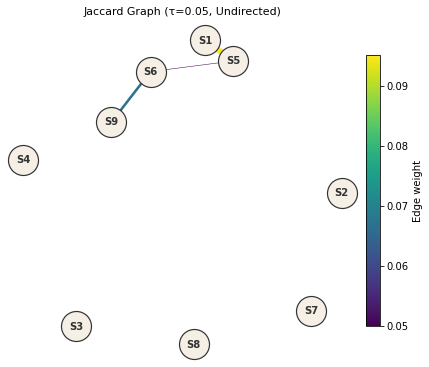

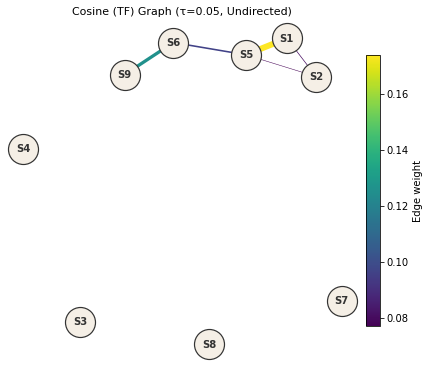

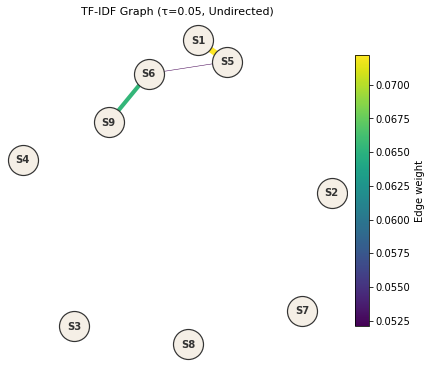

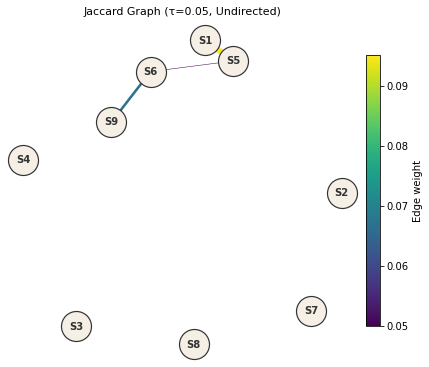

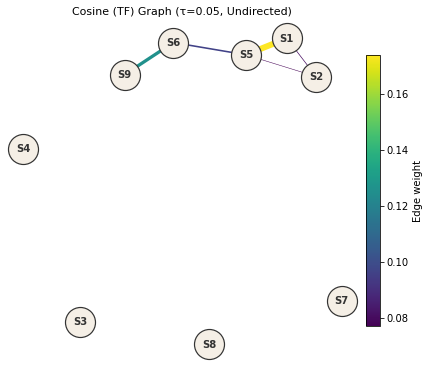

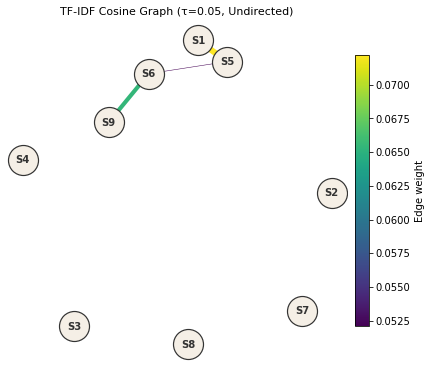

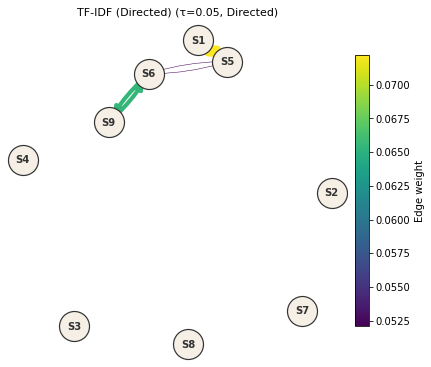

In [12]:
# --- VISUALIZE GRAPHS FROM SIMILARITY MATRICES ---
visualize_graph_from_matrix(M_jac,   sentences=original_Articles, title="Jaccard Graph",   tau=0.05, directed=False)
visualize_graph_from_matrix(M_cos,   sentences=original_Articles, title="Cosine (TF) Graph", tau=0.05, directed=False)
visualize_graph_from_matrix(M_tfidf, sentences=original_Articles, title="TF-IDF Graph",    tau=0.05, directed=False)

visualize_all_three(M_jac, M_cos, M_tfidf, sentences=original_Articles, tau=0.05, directed=False, layout="spring")

visualize_graph_from_matrix(M_tfidf, sentences=original_Articles, title="TF-IDF (Directed)", tau=0.05, directed=True)




# CHECKED ____________


In [14]:
# -------- TextRank Algorithm --------

class TextRank:
    """
    Implements the TextRank algorithm for sentence ranking.
    Uses manual matrix operations (no numpy).
    """
    def __init__(self, P, d=0.85, eps=1e-6, max_iter=100):
        self.P = P                # row-stochastic matrix
        self.n = manual_set_length(P)
        self.d = d
        self.eps = eps
        self.max_iter = max_iter
        self.r = [1.0 / self.n for _ in range(self.n)] if self.n > 0 else []
        self.history = []         # to store L1 differences at each iteration

    def iterate(self):
        """Run iterative rank computation until convergence."""
        if self.n == 0:
            return []

        teleport = (1.0 - self.d) / self.n

        for _ in range(self.max_iter):
            r_next = [0.0 for _ in range(self.n)]
            for i in range(self.n):
                ri = self.r[i]
                row = self.P[i]
                for j in range(self.n):
                    r_next[j] += self.d * ri * row[j]

            # add teleportation to each node
            for j in range(self.n):
                r_next[j] += teleport

            # L1-norm difference
            diff = 0.0
            for j in range(self.n):
                diff += abs(r_next[j] - self.r[j])

            self.history.append(diff)   # record convergence progress

            self.r = r_next
            if diff < self.eps:
                break

        self._normalize()
        return self.r

    def _normalize(self):
        """Normalize rank vector to sum to 1."""
        s = 0.0
        for v in self.r:
            s += v
        if s > 0.0:
            self.r = [v / s for v in self.r]




#chcked ____________

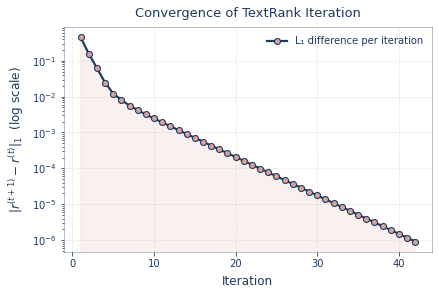

In [ ]:
# ====== CONVERGENCE OF TEXTRANK ITERATION (class-based) ======
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- Project color palette ---
deepblue = "#1e3a5f"
goldenorange = "#d7a49a"

# assume you already ran:
# textrank = TextRank(P, d=0.85, eps=1e-6, max_iter=100)
# scores = textrank.iterate()

# Extract the recorded L1 differences
history = textrank.history

if not history:
    print("⚠️ No convergence data available. Run textrank.iterate() first.")
else:
    plt.figure(figsize=(6.2, 4.2))

    # Plot main curve
    plt.plot(
        range(1, len(history) + 1),
        history,
        marker='o',
        markersize=6,
        markerfacecolor=goldenorange,
        markeredgecolor=deepblue,
        markeredgewidth=1.1,
        color=deepblue,
        linewidth=2.2,
        label="L₁ difference per iteration"
    )

    # Fill area under curve for visual contrast
    plt.fill_between(
        range(1, len(history) + 1),
        history,
        color=goldenorange,
        alpha=0.15
    )

    # Log scale for exponential decay
    plt.yscale('log')

    # Axis labels and title
    plt.xlabel("Iteration", fontsize=12, color=deepblue, labelpad=6)
    plt.ylabel(r"$\|r^{(t+1)} - r^{(t)}\|_1$  (log scale)", fontsize=12, color=deepblue, labelpad=6)
    plt.title("Convergence of TextRank Iteration", fontsize=13, color=deepblue, pad=10)

    # Grid and ticks
    plt.grid(alpha=0.3, linestyle='--')
    plt.tick_params(colors=deepblue, labelsize=10)

    # Style borders
    for spine in plt.gca().spines.values():
        spine.set_edgecolor(deepblue)
        spine.set_alpha(0.4)

    # Legend and layout
    plt.legend(frameon=False, fontsize=10, loc='upper right', labelcolor=deepblue)
    plt.tight_layout()

    plt.show()


# CHECKED ____________


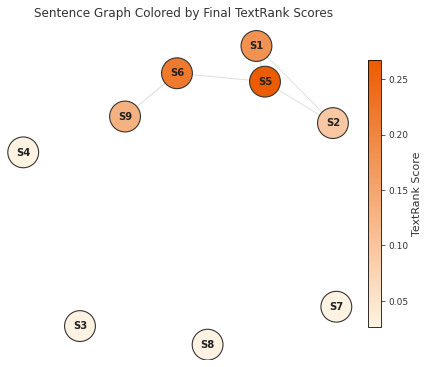

✅ Saved textrank_scores_heatmap.png


In [30]:
# ====== SENTENCE GRAPH COLORED BY TEXTRANK SCORES (class-based) ======
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np

# --- Custom color palette (beige → deep orange) ---
THEME_COLORS = ["#FEF3E2", "#EB5B00"]  # light → deep orange
cmap = mcolors.LinearSegmentedColormap.from_list("custom_theme", THEME_COLORS)

# --- Assume you already ran class-based summarizer ---
# idx, summary, scores, P, G = summarize_textrank(...)

n = G.n
r_arr = np.array(scores)

# --- Build NetworkX graph from your Graph class ---
G_nx = nx.Graph()
G_nx.add_nodes_from(range(n))
for node in G.nodes:
    for j, w in node.edges:
        G_nx.add_edge(node.id, j, weight=w)

# --- Prepare layout and normalized colors ---
pos = nx.spring_layout(G_nx, seed=42)
r_norm = (r_arr - r_arr.min()) / (r_arr.max() - r_arr.min() + 1e-12)
node_colors = cmap(r_norm)

# --- Plot styling ---
plt.figure(figsize=(6.2, 5.2))

# Nodes
nx.draw_networkx_nodes(
    G_nx, pos,
    node_color=node_colors,
    node_size=950,
    edgecolors="#333333",
    linewidths=1.1
)

# Edges
nx.draw_networkx_edges(
    G_nx, pos,
    edge_color="#d9d9d9",
    width=[0.8 + 3.0 * G_nx[u][v]['weight'] for u, v in G_nx.edges()],
    alpha=0.9
)

# Labels
nx.draw_networkx_labels(
    G_nx, pos,
    labels={i: f"S{i+1}" for i in range(n)},
    font_size=10,
    font_weight="bold",
    font_color="#222222"
)

# --- Colorbar for node intensity ---
sm = plt.cm.ScalarMappable(
    norm=plt.Normalize(vmin=r_arr.min(), vmax=r_arr.max()),
    cmap=cmap
)
cbar = plt.colorbar(sm, shrink=0.8, pad=0.02)
cbar.set_label("TextRank Score", fontsize=11, color="#333333")
cbar.ax.tick_params(labelsize=9, colors="#333333")

# --- Final touches ---
plt.title("Sentence Graph Colored by Final TextRank Scores",
          fontsize=12, color="#333333", pad=10)
plt.axis("off")
plt.tight_layout()
plt.savefig("textrank_scores_heatmap.png", dpi=300, bbox_inches='tight', transparent=False)
plt.show()

print("✅ Saved textrank_scores_heatmap.png")


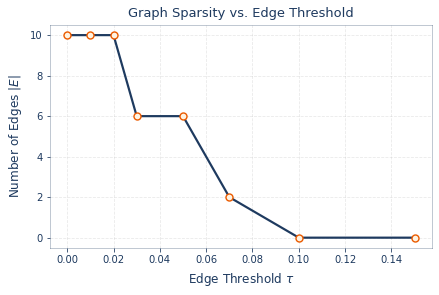

✅ Saved styled plot -> fig_tau_edges.png


In [ ]:
# ====== GRAPH SPARSITY vs EDGE THRESHOLD (class-based) ======
import matplotlib.pyplot as plt
import numpy as np

def plot_edges_vs_tau_styled_class_based(token_lists, metric="tfidf", save_path="fig_tau_edges.png"):
    """
    Plot how the number of edges |E| changes with threshold τ, using your class-based Graph.
    """
    deepblue      = "#1e3a5f"
    goldenorange  = "#EB5B00"
    lightbeige    = "#FEF3E2"

    # --- Compute similarity matrix once ---
    M = build_similarity_matrix(token_lists, metric=metric)
    n = manual_set_length(token_lists)

    taus = [0.00, 0.01, 0.02, 0.03, 0.05, 0.07, 0.10, 0.15]
    edge_counts = []

    # --- Loop over thresholds and count edges ---
    for tau in taus:
        G = Graph(n)
        G.build_from_matrix(M, tau=tau)
        total_edges = 0
        i = 0
        while i < n:
            total_edges += manual_set_length(G.nodes[i].edges)
            i += 1
        edge_counts.append(total_edges)

    # --- Plot setup ---
    plt.figure(figsize=(6.2, 4.2))

    # Main curve
    plt.plot(
        taus, edge_counts,
        marker='o',
        markersize=7,
        markerfacecolor=lightbeige,
        markeredgecolor=goldenorange,
        markeredgewidth=1.4,
        linewidth=2.2,
        color=deepblue
    )

    plt.xlabel(r"Edge Threshold $\tau$", fontsize=12, color=deepblue, labelpad=6)
    plt.ylabel(r"Number of Edges $|E|$", fontsize=12, color=deepblue, labelpad=6)
    plt.title("Graph Sparsity vs. Edge Threshold", fontsize=13, color=deepblue, pad=8)

    plt.grid(alpha=0.28, linestyle='--')
    plt.tick_params(colors=deepblue, labelsize=10)

    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor(deepblue)
        spine.set_alpha(0.35)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=False)
    plt.show()

    print(f"✅ Saved styled plot -> {save_path}")


# --- Run it on your tokenized data ---
plot_edges_vs_tau_styled_class_based(cleaned_tokens, metric="tfidf", save_path="fig_tau_edges.png")


#CHECKED ____________


### Choosing and Sorting

In [ ]:
#---------- MMR Top-k ----------

class MMRSelector:
    """
    Pure algorithmic Maximal Marginal Relevance (MMR) selector for extractive summarization.
    Converts select_top_k and select_top_k_mmr into an object-based interface.
    """
    def __init__(self, sentences, tokens_list, scores, metric="tfidf"):
        self.sentences = sentences
        self.tokens_list = tokens_list
        self.scores = scores
        self.metric = metric
        self.n = manual_set_length(sentences)
        self.sim_M = build_similarity_matrix(tokens_list, metric=metric)

    # ---------- helper methods ----------
    def _manual_length(self, lst):
        c = 0
        for _ in lst:
            c += 1
        return c

    def _selection_sort_indices_desc_by_scores(self, indices):
        """In-place selection sort of indices by descending score."""
        n = self._manual_length(indices)
        for i in range(n):
            max_j = i
            for j in range(i + 1, n):
                if self.scores[indices[j]] > self.scores[indices[max_j]]:
                    max_j = j
            if max_j != i:
                indices[i], indices[max_j] = indices[max_j], indices[i]

    # ---------- plain top-k ----------
    def select_top_k(self, k):
        n = self.n
        if k < 1:
            return [], []
        if k > n:
            k = n

        # build indices 0..n-1
        idx = [0] * n
        i = 0
        while i < n:
            idx[i] = i
            i += 1

        # sort by score
        self._selection_sort_indices_desc_by_scores(idx)

        # take top-k
        top_k = [0] * k
        i = 0
        while i < k:
            top_k[i] = idx[i]
            i += 1

        # collect sentences
        out_sents = [""] * k
        i = 0
        while i < k:
            out_sents[i] = self.sentences[top_k[i]]
            i += 1

        return top_k, out_sents

    # ---------- MMR top-k ----------
    def select_top_k_mmr(self, k, lam=0.8):
        n = self.n
        if k < 1:
            return [], []
        if k > n:
            k = n

        # clamp λ
        if lam < 0.0: lam = 0.0
        if lam > 1.0: lam = 1.0

        selected = [-1] * k
        m = 0

        def max_sim_to_selected(i):
            if m == 0:
                return 0.0
            ms = 0.0
            t = 0
            while t < m:
                j = selected[t]
                s = self.sim_M[i][j]
                if s > ms:
                    ms = s
                t += 1
            return ms

        def is_selected(i):
            t = 0
            while t < m:
                if selected[t] == i:
                    return True
                t += 1
            return False

        while m < k:
            best_i = -1
            best_val = -1e18
            i = 0
            while i < n:
                if not is_selected(i):
                    redundancy = max_sim_to_selected(i)
                    val = lam * self.scores[i] - (1.0 - lam) * redundancy
                    if val > best_val:
                        best_val = val
                        best_i = i
                i += 1
            selected[m] = best_i
            m += 1

        # build output sentences
        out_sents = [""] * k
        i = 0
        while i < k:
            out_sents[i] = self.sentences[selected[i]]
            i += 1

        return selected, out_sents
    
#checked ____________



In [ ]:
# --- Build transition matrix from your Graph class ---
G = Graph(n=len(cleaned_tokens))
G.build_from_matrix(M_tfidf, tau=0.0)    # or tau=0.05 for pruning
P_tfidf = G.to_transition_matrix()

# --- Run TextRank algorithm ---
textrank = TextRank(P_tfidf, d=0.85, eps=1e-6, max_iter=100)
scores = textrank.iterate()

# --- Plain top-k selection ---
selector = MMRSelector(original_Articles, cleaned_tokens, scores, metric="tfidf")
idx_plain, summary_plain = selector.select_top_k(k=3)

# --- MMR with TF-IDF redundancy (recommended) ---
idx_mmr, summary_mmr = selector.select_top_k_mmr(k=3, lam=0.75)

# --- MMR with Jaccard redundancy (baseline) ---
selector_j = MMRSelector(original_Articles, cleaned_tokens, scores, metric="jaccard")
idx_mmr_j, summary_mmr_j = selector_j.select_top_k_mmr(k=3, lam=0.8)


#checked ____________


In [ ]:
def summarize_textrank(
    article_text,
    k=3,
    metric="tfidf",
    d=0.85,
    tau=0.05,           # edge threshold; 0.0 = no pruning
    use_mmr=False,
    lam=0.8,
    return_all=False
):
    """
    Run full TextRank summarization (class-based version).
    """

    # 1) --- Preprocessing ---
    sentences, tokens_list = preprocess_text_manual(article_text)
    n = manual_set_length(sentences)
    if n == 0:
        return [], [], [], [], [] if not return_all else ([], [], [], [], [], [])

    # clamp k
    if k < 1: k = 1
    if k > n: k = n

    # 2) --- Similarity matrix ---
    M = build_similarity_matrix(tokens_list, metric=metric)

    # 3) --- Graph + Transition matrix ---
    G = Graph(n)
    G.build_from_matrix(M, tau=tau)
    P = G.to_transition_matrix()

    # 4) --- TextRank iteration ---
    textrank = TextRank(P, d=d, eps=1e-6, max_iter=100)
    scores = textrank.iterate()

    # 5) --- Sentence selection ---
    selector = MMRSelector(sentences, tokens_list, scores, metric=metric)

    if use_mmr:
        idx, summary = selector.select_top_k_mmr(k=k, lam=lam)
    else:
        idx, summary = selector.select_top_k(k=k)

    # 6) --- Return results ---
    if not return_all:
        return idx, summary, scores, P, G

    # also return ranked indices (desc by score)
    all_idx = [i for i in range(n)]
    selection_sort_indices_desc_by_scores(all_idx, scores)
    ranked_idx = all_idx

    return idx, summary, scores, P, G, ranked_idx

#checked ____________


In [ ]:
# --- EXPERIMENT: Varying tau values ---
tau_values = [0.0, 0.05, 0.1, 0.2]  # adjust or add more if you like

for tau_val in tau_values:
    print("\n===============================================================")
    print(f"==================== RUN with tau = {tau_val:.2f} ====================")

    # --- Run full TextRank summarization pipeline (class-based) ---
    idx_run, summary_run, scores_run, P_run, G_run = summarize_textrank(
        article_text_input,
        k=3,               # top-3 sentences
        metric="tfidf",    # "tfidf" | "cosine" | "jaccard"
        d=0.85,            # damping factor (random-walk teleportation)
        tau=tau_val,       # prune weak edges below tau 
        use_mmr=True,      # activate redundancy control
        lam=0.8            # trade-off parameter (0.8 favors rank; <0.7 favors diversity)
    )

    # --- Display summary output ---
    print("\n🧾 TEXT RANK SUMMARY (rank order):")
    for s in summary_run:
        print("•", s)

    # --- Display node-level (sentence) importance scores ---
    print("\n📊 NODE SCORES (TextRank):")
    for i, sc in enumerate(scores_run, start=1):
        print(f"S{i}: {sc:.4f}")

    # --- Display graph statistics ---
    num_nodes = manual_set_length(P_run)
    num_edges = 0
    for node in G_run.nodes:
        num_edges += manual_set_length(node.edges)

    print("\n📈 GRAPH STATISTICS:")
    print(f"Number of sentences (|V|): {num_nodes}")
    print(f"Number of directed edges (|E|): {num_edges}")
    print(f"Edge threshold (tau): {tau_val}")
    print(f"Damping factor (d): 0.85")
    print(f"Redundancy control (MMR): True  (lambda = 0.8)")

    # --- Optional: display selected indices (rank + original order) ---
    print("\nSelected sentence indices (rank order):", idx_run)
    sorted_idx = sorted(idx_run)
    print("Selected sentence indices (original order):", sorted_idx)

    # --- Optional: print same sentences in original text order ---
    print("\n🧾 TEXT RANK SUMMARY (original order):")
    for i in sorted_idx:
        print(f"• Sentence {i+1}")

    # --- Optional: sanity check for row-stochasticity ---
    print("\nRow sums of P (should all ≈ 1.0):")
    for i, row in enumerate(P_run):
        row_sum = sum(row)
        print(f"Row {i+1}: {row_sum:.3f}")

print("\n===============================================================")
print("✅ Experiment complete. Compare how summaries differ across tau values.")




#Checked ____________



==================== RUN with tau = 0.00 ====================

🧾 TEXT RANK SUMMARY (rank order):
• Officials argued that phased work keeps most areas open and makes the park safer after dark.
• Parents repeated that the improvements will make evenings safer and more enjoyable for children.
• City officials unveiled a €2_5-million plan to renovate Greenfield Park by May 2026.

📊 NODE SCORES (TextRank):
S1: 0.1806
S2: 0.0962
S3: 0.0268
S4: 0.0268
S5: 0.2672
S6: 0.2186
S7: 0.0268
S8: 0.0268
S9: 0.1302

📈 GRAPH STATISTICS:
Number of sentences (|V|): 9
Number of directed edges (|E|): 10
Edge threshold (tau): 0.0
Damping factor (d): 0.85
Redundancy control (MMR): True  (lambda = 0.8)

Selected sentence indices (rank order): [4, 5, 0]
Selected sentence indices (original order): [0, 4, 5]

🧾 TEXT RANK SUMMARY (original order):
• Sentence 1
• Sentence 5
• Sentence 6

Row sums of P (should all ≈ 1.0):
Row 1: 1.000
Row 2: 1.000
Row 3: 1.000
Row 4: 1.000
Row 5: 1.000
Row 6: 1.000
Row 7: 1.000
Row

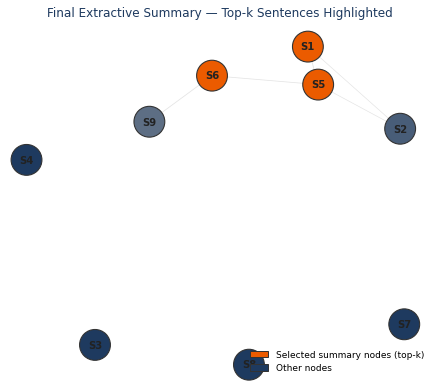

In [ ]:
# ========= Visualized Top-k Summary Nodes in Graph =========
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np

# === Project color palette ===
deepblue = "#1e3a5f"
goldenorange = "#EB5B00"
lightbeige = "#FEF3E2"
neutralgray = "#b5b5b5"

# --- Use results from summarize_textrank ---
# assume you already ran:
# idx, summary, scores, P, G = summarize_textrank(...)

n = G.n
r_arr = np.array(scores)

# --- Build networkx Graph from your Graph object ---
G_nx = nx.Graph()
G_nx.add_nodes_from(range(n))

for node in G.nodes:
    for j, w in node.edges:
        G_nx.add_edge(node.id, j, weight=w)

# --- Layout and normalize ranks ---
pos = nx.spring_layout(G_nx, seed=42)
r_norm = (r_arr - r_arr.min()) / (r_arr.max() - r_arr.min() + 1e-12)

# --- Select top-k nodes ---
top_k = 3
top_ids = np.argsort(r_arr)[::-1][:top_k]

# --- Define node colors ---
node_colors = []
for i in range(n):
    if i in top_ids:
        node_colors.append(goldenorange)
    else:
        blend = 0.35 + 0.65 * (1 - r_norm[i])
        node_colors.append(mcolors.to_hex(
            np.array(mcolors.to_rgb(deepblue)) * blend +
            np.array(mcolors.to_rgb(lightbeige)) * (1 - blend)
        ))


# --- Draw graph ---
plt.figure(figsize=(6.2, 5.5))
edge_widths = [0.6 + 2.8 * G_nx[u][v]['weight'] for u, v in G_nx.edges()]

# Edges (background)
nx.draw_networkx_edges(
    G_nx, pos,
    edge_color="#dddddd",
    width=edge_widths,
    alpha=0.8
)

# Nodes
nx.draw_networkx_nodes(
    G_nx, pos,
    node_color=node_colors,
    edgecolors="#333333",
    linewidths=1.1,
    node_size=950
)

# Labels
nx.draw_networkx_labels(
    G_nx, pos,
    labels={i: f"S{i+1}" for i in range(n)},
    font_size=10,
    font_weight="bold",
    font_color="#222222"
)

# --- Legend ---
from matplotlib.patches import Patch
legend_elems = [
    Patch(facecolor=goldenorange, edgecolor="#333333", label="Selected summary nodes (top-k)"),
    Patch(facecolor=deepblue, edgecolor="#333333", label="Other nodes")
]
plt.legend(handles=legend_elems, loc="lower right", frameon=False, fontsize=9)

# --- Final touches ---
plt.title("Final Extractive Summary — Top-k Sentences Highlighted",
          fontsize=12, color=deepblue, pad=10)
plt.axis("off")
plt.tight_layout()
plt.savefig("textrank_summary_graph_colored.png", dpi=300, bbox_inches='tight', transparent=False)
plt.show()


#Checked ____________


In [24]:
# ====== COMPARISON SUMMARY (across tau values) ======

# Define the tau values you tested — must match those in your previous loop
tau_values = [0.0, 0.05, 0.1, 0.2]

print("\n===============================================================")
print("📊 COMPARISON OF RESULTS ACROSS TAU VALUES")
print("===============================================================")
print(f"{'Tau':<8} {'|E| (edges)':<14} {'Top-3 Sentences (indices)':<30} {'Top-1 Sentence ID':<20}")
print("-" * 80)

# run summarize_textrank once for each tau, collect quick stats
for tau_val in tau_values:
    idx_run, summary_run, scores_run, P_run, G_run = summarize_textrank(
        article_text_input,
        k=3,
        metric="tfidf",
        d=0.85,
        tau=tau_val,
        use_mmr=True,
        lam=0.8
    )

    # --- Count edges manually from the Graph object ---
    num_edges = 0
    for node in G_run.nodes:
        num_edges += manual_set_length(node.edges)

    # get top-1 sentence id by raw score (highest importance)
    all_idx = [i for i in range(manual_set_length(scores_run))]
    selection_sort_indices_desc_by_scores(all_idx, scores_run)
    top1_id = all_idx[0]

    # make a compact string of top-k indices
    topk_str = ', '.join(str(i) for i in idx_run)

    print(f"{tau_val:<8.2f} {num_edges:<14} {topk_str:<30} {top1_id:<20}")

print("-" * 80)
print("✅ Table shows how graph sparsity (|E|) and top-ranked sentences change with tau.")
print("Note: Fewer edges = sparser graph = more selective connections.")



📊 COMPARISON OF RESULTS ACROSS TAU VALUES
Tau      |E| (edges)    Top-3 Sentences (indices)      Top-1 Sentence ID   
--------------------------------------------------------------------------------


NameError: name 'selection_sort_indices_desc_by_scores' is not defined

### RESULT

In [ ]:
# ====== APPLY SUMMARIZER TO ENTIRE toy_set (class-based, proportional k) ======

def auto_k_for_proportional(sent_count, alpha=0.25, k_min=1, k_max=3):
    """Decide k ≈ alpha * n, clamped to [k_min, k_max]."""
    if sent_count <= 0:
        return 0
    k = int(round(alpha * sent_count))
    if k < k_min:
        k = k_min
    if k > k_max:
        k = k_max
    if k > sent_count:
        k = sent_count
    return k


def summarize_row_text_class_based(
    row_text,
    metric="tfidf",
    d=0.85,
    tau=0.05,
    use_mmr=True,
    lam=0.8
):
    """Summarize one article using the class-based TextRank pipeline."""
    # --- Preprocess text ---
    sentences, tokens_list = preprocess_text_manual(row_text)
    n = manual_set_length(sentences)
    if n == 0:
        return {
            "summary_indices": [],
            "summary_sentences": [],
            "sent_count": 0,
            "edge_count": 0,
            "top_score": 0.0,
        }

    # --- Adaptive k ---
    k = auto_k_for_proportional(n, alpha=0.25, k_min=1, k_max=3)

    # --- Similarity matrix + Graph ---
    M = build_similarity_matrix(tokens_list, metric=metric)
    G = Graph(n)
    G.build_from_matrix(M, tau=tau)
    P = G.to_transition_matrix()

    # --- Run TextRank ---
    textrank = TextRank(P, d=d, eps=1e-6, max_iter=100)
    scores = textrank.iterate()

    # --- Sentence selection ---
    selector = MMRSelector(sentences, tokens_list, scores, metric=metric)
    if use_mmr:
        idx, summary = selector.select_top_k_mmr(k=k, lam=lam)
    else:
        idx, summary = selector.select_top_k(k=k)

    # --- Collect statistics ---
    edge_count = 0
    for node in G.nodes:
        edge_count += manual_set_length(node.edges)

    return {
        "summary_indices": idx,
        "summary_sentences": summary,
        "sent_count": n,
        "edge_count": edge_count,
        "top_score": max(scores) if scores else 0.0,
    }


# --- Apply summarizer to each article in toy_set ---
results = []
for i in range(len(toy_set)):
    print(f"\nProcessing row {i+1}/{len(toy_set)} ...")
    art = toy_set.loc[i, "article"]
    out = summarize_row_text_class_based(
        art, metric="tfidf", d=0.85, tau=0.05, use_mmr=True, lam=0.8
    )
    results.append(out)

# --- Attach summaries and stats to DataFrame ---
toy_set["summary_indices"]   = [r["summary_indices"]   for r in results]
toy_set["summary_sentences"] = [r["summary_sentences"] for r in results]
toy_set["sent_count"]        = [r["sent_count"]        for r in results]
toy_set["edge_count"]        = [r["edge_count"]        for r in results]
toy_set["top_score"]         = [r["top_score"]         for r in results]

# --- Pretty print summaries ---
for i in range(len(toy_set)):
    print("\n===============================================================")
    print(f"📰 ARTICLE ID: {toy_set.loc[i, 'id']}")
    print("🧾 TEXT RANK SUMMARY:")
    for s in toy_set.loc[i, "summary_sentences"]:
        print("•", s)
    print("\nREF HIGHLIGHT:", toy_set.loc[i, "highlights"])

print("\n===============================================================")
print("✅ Summarization complete for all rows in toy_set (class-based, proportional k).")


#Checked ____________   



Processing row 1/5 ...

Processing row 2/5 ...

Processing row 3/5 ...

Processing row 4/5 ...

Processing row 5/5 ...

📰 ARTICLE ID: ed0fed726929c1eeabe6c390e47128dbb7d7a055
🧾 TEXT RANK SUMMARY:
• Sun's out: Brighton beach was packed with Britons enjoying the unexpected sunshine to start the long weekend as temperatures hit 17C across the south coast .
• Three day forecast: Tomorrow sunny spells and warm weather is set to cover southern England, but the heavy rain up north is set to stay .
• Though rain poured down in the north west, the north east enjoyed a bright spell at midday today with sun shining in Harrogate (pictured) ahead of the rainy weekend .

REF HIGHLIGHT: People enjoyed temperatures of 17C at Brighton beach in West Sussex and Weymouth in Dorset .
Asda claims it will sell a million sausages over long weekend despite night temperatures dropping to minus 1C .
But the good weather has not been enjoyed by all as the north west and Scotland have seen heavy rain .

📰 ARTICLE

### Some more visuallizations for the report

Processed article 1/5: 31 sentences → 27.4 ms
Processed article 2/5: 37 sentences → 32.7 ms
Processed article 3/5: 43 sentences → 41.4 ms
Processed article 4/5: 14 sentences → 17.4 ms
Processed article 5/5: 52 sentences → 82.6 ms


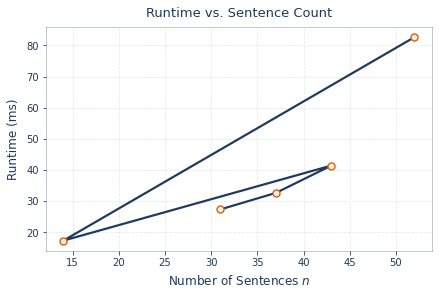

✅ Saved fig_runtime_vs_n.png


In [ ]:
# ====== RUNTIME VS. SENTENCE COUNT EXPERIMENT (class-based) ======
import time
import matplotlib.pyplot as plt

# Theme colors
deepblue      = "#1e3a5f"
goldenorange  = "#EB5B00"
lightbeige    = "#FEF3E2"

def measure_runtime_no_pruning(article_text):
    """Measure runtime (ms) of summarization without pruning or MMR."""
    start = time.time()
    # --- run full summarizer, but ignore outputs ---
    summarize_textrank(
        article_text,
        k=3,
        metric="tfidf",
        d=0.85,
        tau=0.0,          # <-- no pruning
        use_mmr=False     # <-- no redundancy filtering
    )
    end = time.time()
    return (end - start) * 1000.0   # convert to ms


# --- Collect data from toy_set ---
ns = []        # number of sentences
times = []     # runtime in ms

for i in range(len(toy_set)):
    text = toy_set.loc[i, "article"]
    sentences, _ = preprocess_text_manual(text)
    n = manual_set_length(sentences)
    if n == 0:
        continue
    t = measure_runtime_no_pruning(text)
    ns.append(n)
    times.append(t)
    print(f"Processed article {i+1}/{len(toy_set)}: {n} sentences → {t:.1f} ms")

# --- Plot (styled) ---
plt.figure(figsize=(6.2, 4.2))
plt.plot(
    ns, times,
    marker='o',
    markersize=7,
    markerfacecolor=lightbeige,
    markeredgecolor=goldenorange,
    markeredgewidth=1.4,
    linewidth=2.2,
    color=deepblue
)

plt.xlabel("Number of Sentences $n$", fontsize=12, color=deepblue, labelpad=6)
plt.ylabel("Runtime (ms)", fontsize=12, color=deepblue, labelpad=6)
plt.title("Runtime vs. Sentence Count", fontsize=13, color=deepblue, pad=10)

plt.grid(alpha=0.28, linestyle='--')
plt.tick_params(colors=deepblue, labelsize=10)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor(deepblue)
    spine.set_alpha(0.35)

plt.tight_layout()
plt.savefig("fig_runtime_vs_n.png", dpi=300, bbox_inches='tight', transparent=False)
plt.show()

print("✅ Saved fig_runtime_vs_n.png")

#Checked ____________


In [27]:
deepblue      = "#1e3a5f"
goldenorange  = "#EB5B00"
lightbeige    = "#FEF3E2"

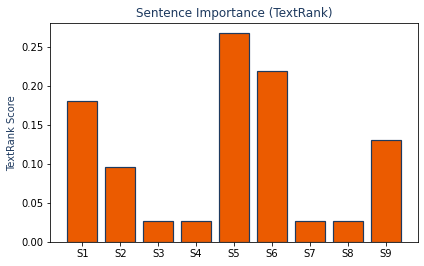

In [ ]:
#--- Plot TextRank scores as bar chart ---
def plot_textrank_scores(scores):
    x = range(len(scores))
    plt.figure(figsize=(6, 3.8))
    plt.bar(x, scores, color=goldenorange, edgecolor=deepblue, linewidth=1.2)
    plt.xticks(x, [f"S{i+1}" for i in x])
    plt.ylabel("TextRank Score", color=deepblue)
    plt.title("Sentence Importance (TextRank)", color=deepblue)
    plt.tight_layout()
    plt.savefig("fig_textrank_scores.png", dpi=300, bbox_inches='tight')
    plt.show()

plot_textrank_scores(scores)


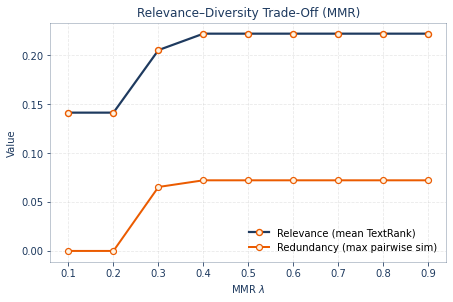

✅ Saved fig_mmr_tradeoff.png


In [ ]:
# ====== MMR TRADE-OFF CURVES (class-based) ======
import itertools
import matplotlib.pyplot as plt

# Theme
deepblue      = "#1e3a5f"
goldenorange  = "#EB5B00"
lightbeige    = "#FEF3E2"

def max_pairwise_sim(indices, simM):
    """Return the maximum pairwise similarity among the selected indices."""
    if len(indices) < 2:
        return 0.0
    m = 0.0
    for i, j in itertools.combinations(indices, 2):
        if simM[i][j] > m:
            m = simM[i][j]
    return m


def mmr_tradeoff_curves_class_based(sentences, tokens, scores, k=3, lambdas=None, metric="tfidf"):
    """Compute MMR trade-off curves using the class-based selector."""
    if lambdas is None:
        lambdas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    # Precompute redundancy similarity matrix
    redund_sim = build_similarity_matrix(tokens, metric=metric)
    rel_vals, red_vals = [], []

    # Instantiate selector once
    selector = MMRSelector(sentences, tokens, scores, metric=metric)

    for lam in lambdas:
        idx, _ = selector.select_top_k_mmr(k=k, lam=lam)
        # relevance = mean TextRank score of selected sentences
        rel = sum(scores[i] for i in idx) / len(idx)
        # redundancy = max pairwise similarity among selected sentences
        red = max_pairwise_sim(idx, redund_sim)
        rel_vals.append(rel)
        red_vals.append(red)

    return lambdas, rel_vals, red_vals


# ---- Compute & plot for your chosen article ----
# assume you already ran the summarizer and have:
# sentences = original_Articles
# tokens = cleaned_tokens
# scores = scores (from TextRank.iterate())

lams, rel_vals, red_vals = mmr_tradeoff_curves_class_based(
    original_Articles, cleaned_tokens, scores, k=3, metric="tfidf"
)

plt.figure(figsize=(6.4, 4.3))

# Relevance curve
plt.plot(
    lams, rel_vals,
    marker='o',
    markerfacecolor=lightbeige,
    markeredgecolor=goldenorange,
    markeredgewidth=1.4,
    color=deepblue,
    linewidth=2.2,
    label="Relevance (mean TextRank)"
)

# Redundancy curve
plt.plot(
    lams, red_vals,
    marker='o',
    markerfacecolor=lightbeige,
    markeredgecolor=goldenorange,
    markeredgewidth=1.2,
    color=goldenorange,
    linewidth=2.0,
    label="Redundancy (max pairwise sim)"
)

plt.xlabel(r"MMR $\lambda$", color=deepblue)
plt.ylabel("Value", color=deepblue)
plt.title("Relevance–Diversity Trade-Off (MMR)", color=deepblue)
plt.grid(alpha=0.28, linestyle='--')
plt.tick_params(colors=deepblue, labelsize=10)
ax = plt.gca()
for s in ax.spines.values():
    s.set_edgecolor(deepblue)
    s.set_alpha(0.35)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("fig_mmr_tradeoff.png", dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved fig_mmr_tradeoff.png")


#Checked ____________